In [227]:
from collections import Counter
import pandas as pd
import numpy as np
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
#from model import 
from flask import Flask, request, render_template, url_for
from pymongo import MongoClient
from bson import json_util

import requests
import matplotlib.pyplot as plt

In [2]:
client = MongoClient()
db = client.yelp
rdb = db.reviews

reviews = rdb.find({}, {'_id': False, 'review_text': True, 'review_rating': True })

In [8]:
type(reviews)

pymongo.cursor.Cursor

In [12]:
review_text = []
review_rating = []
for review in reviews:
    if 'review_text' in review.keys():
        review_text.append(review['review_text'])
        review_rating.append(review['review_rating'])

In [14]:
len(review_text), len(review_rating)

(24079, 24079)

In [54]:
rt = pd.DataFrame(review_text)

In [56]:
rt.columns = ['review_text']
rt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24079 entries, 0 to 24078
Data columns (total 1 columns):
review_text    24079 non-null object
dtypes: object(1)
memory usage: 188.2+ KB


In [57]:
rt['length'] = rt['review_text'].map(lambda x: len(x))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a0dddf668>]],
      dtype=object)

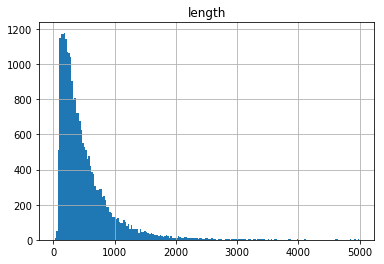

In [62]:
rt.hist(bins=200)

In [83]:
rt.describe()

,length
count,24079.000000
mean,504.062004
std,456.747081
min,21.000000
25%,211.000000
50%,367.000000
75%,636.000000
max,4989.000000


In [15]:
X = np.array(review_text)

In [49]:
y = np.array(review_rating)

# Model 1: Predict 1-5

In [79]:
X = np.array(review_text)
y = np.array(review_rating)

In [80]:
vect = TfidfVectorizer(lowercase=True, stop_words="english")
model_vect = vect.fit_transform(X)

model = MultinomialNB()
model.fit(model_vect, y)
model.score(model_vect, y)

0.5717014826197101

## plot 1-5

In [224]:
def sigmoid(x):
    a = []
    for item in x:
        a.append(1/(1+np.exp(-item)))
    return a

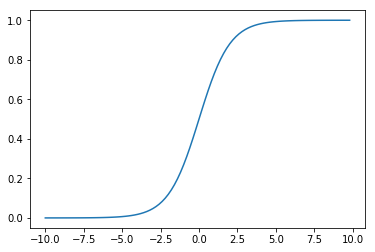

In [228]:

x = np.arange(-10., 10., 0.2)
sig = sigmoid(x)
plt.plot(x,sig)
plt.show()

# Model 2: 1-3=Bad and 4&5=Good

In [50]:
y[y=='1.0'] = 0
y[y=='2.0'] = 0
y[y=='3.0'] = 0
y[y=='4.0'] = 1
y[y=='5.0'] = 1

In [51]:
y=y.astype(int)

In [52]:
vect = TfidfVectorizer(lowercase=True, stop_words="english")
model_vect = vect.fit_transform(X)

model = MultinomialNB()
model.fit(model_vect, y)
model.score(model_vect, y)

0.8818057228290211

In [223]:
# Save Vectorizer
with open("../src/tfidf_vectorizer.pickle", 'wb') as pikl:
    pickle.dump(vect, pikl, protocol=2)
# Save Multinomial NB Model
with open("../src/nlp_model.pickle", 'wb') as pikl:
    pickle.dump(model, pikl, protocol=2)

# Model 3: Short and Long

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a3557ad30>]],
      dtype=object)

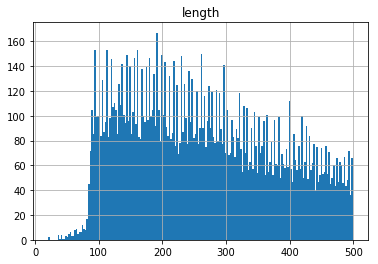

In [86]:
rt[rt['length']<500].hist(bins=200)

# Short

In [90]:

X = rt[rt['length']<500]['review_text'].values
y = np.array(review_rating)
y = y[rt['length']<500]

y[y=='1.0'] = 0
y[y=='2.0'] = 0
y[y=='3.0'] = 0
y[y=='4.0'] = 1
y[y=='5.0'] = 1

y=y.astype(int)

In [91]:
len(X), len(y)

(15519, 15519)

In [92]:
vect = TfidfVectorizer(lowercase=True, stop_words="english")
model_vect = vect.fit_transform(X)

model = MultinomialNB()
model.fit(model_vect, y)
model.score(model_vect, y)

0.8910367936078356

# Long

In [93]:

X = rt[rt['length']>500]['review_text'].values
y = np.array(review_rating)
y = y[rt['length']>500]

y[y=='1.0'] = 0
y[y=='2.0'] = 0
y[y=='3.0'] = 0
y[y=='4.0'] = 1
y[y=='5.0'] = 1

y=y.astype(int)

vect = TfidfVectorizer(lowercase=True, stop_words="english")
model_vect = vect.fit_transform(X)

model = MultinomialNB()
model.fit(model_vect, y)
model.score(model_vect, y)

0.8779001640496836

In [64]:
from sklearn.cluster import KMeans

In [74]:
kmeans = KMeans(n_clusters=20)
kmeans.fit(model_vect)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [75]:
print("\n2) cluster centers:")
print(kmeans.cluster_centers_)


2) cluster centers:
[[0.00207285 0.         0.         ... 0.         0.         0.00068132]
 [0.00069558 0.00087579 0.         ... 0.         0.         0.        ]
 [0.00206057 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.00095258 0.         0.00023703 ... 0.         0.         0.        ]
 [0.00388081 0.         0.         ... 0.         0.         0.        ]
 [0.00279369 0.00027353 0.         ... 0.         0.         0.        ]]


In [76]:
features = vect.get_feature_names()

In [71]:
top_centroids = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
print("\n3) top features (words) for each cluster:")
for num, centroid in enumerate(top_centroids):
    print("%d: %s" % (num, ", ".join(features[i] for i in centroid)))



3) top features (words) for each cluster:
0: food, good, service, place, fast, friendly, really, staff, nice, restaurant
1: order, minutes, time, food, service, said, drive, just, customer, asked
2: place, like, good, just, time, food, love, best, ve, really
3: coffee, starbucks, shop, great, iced, place, good, friendly, love, brew
4: great, food, service, place, friendly, staff, love, good, awesome, atmosphere
5: tacos, burrito, salsa, taco, asada, carne, good, food, mexican, chips
6: chicken, rice, good, food, salad, ordered, fried, sauce, place, like
7: pizza, crust, wings, good, delivery, great, order, place, ordered, cheese


In [77]:
top_centroids = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
print("\n3) top features (words) for each cluster:")
for num, centroid in enumerate(top_centroids):
    print("%d: %s" % (num, ", ".join(features[i] for i in centroid)))


3) top features (words) for each cluster:
0: sushi, roll, rolls, place, good, great, fresh, service, happy, love
1: park, dog, dogs, trail, kids, playground, play, lots, great, parking
2: lunch, salad, good, food, place, great, chicken, service, fresh, time
3: breakfast, eggs, good, bacon, place, toast, food, great, service, hash
4: place, like, just, food, time, love, bar, don, good, service
5: coffee, shop, starbucks, great, iced, place, brew, good, love, friendly
6: tacos, taco, asada, good, fish, carne, salsa, food, place, street
7: location, service, food, time, ve, drive, customer, order, employees, times
8: mexican, food, salsa, authentic, place, good, great, restaurant, chips, best
9: burrito, asada, carne, good, food, burritos, salsa, place, breakfast, cheese
10: burger, fries, burgers, good, food, king, place, cheese, like, just
11: staff, friendly, food, great, place, clean, good, love, nice, super
12: great, service, food, place, love, awesome, atmosphere, good, friendly, 

In [81]:
kmeans = KMeans(n_clusters=12)
kmeans.fit(model_vect)
features = vect.get_feature_names()
top_centroids = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
print("\n3) top features (words) for each cluster:")
for num, centroid in enumerate(top_centroids):
    print("%d: %s" % (num, ", ".join(features[i] for i in centroid)))


3) top features (words) for each cluster:
0: order, minutes, food, time, said, asked, service, just, manager, drive
1: place, food, like, just, service, time, love, bar, best, don
2: good, food, place, service, really, fast, mexican, friendly, nice, restaurant
3: chicken, rice, food, good, ordered, fried, place, salad, sauce, like
4: pizza, crust, wings, good, delivery, great, order, place, ordered, cheese
5: tacos, asada, taco, carne, salsa, good, food, burrito, place, fish
6: sandwich, good, ordered, salad, cheese, like, sauce, place, delicious, bread
7: burger, fries, burgers, good, food, place, king, cheese, like, just
8: great, food, service, place, friendly, love, staff, atmosphere, awesome, good
9: breakfast, eggs, good, place, bacon, burrito, food, great, service, toast
10: coffee, shop, starbucks, great, iced, place, brew, good, friendly, love
11: location, service, food, time, ve, staff, drive, friendly, customer, order


In [94]:
print('KMeans Clustering Loop clusters')
for x in range(8, 19):
    print('KMeans for {} Clusters:'.format(x))
    kmeans = KMeans(n_clusters=x)
    kmeans.fit(model_vect)
    features = vect.get_feature_names()
    top_centroids = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
    print("\n3) top features (words) for each cluster:")
    for num, centroid in enumerate(top_centroids):
        print("%d: %s" % (num, ", ".join(features[i] for i in centroid)))
    
    print()

KMeans Clustering Loop clusters
KMeans for 8 Clusters:

3) top features (words) for each cluster:
0: coffee, donuts, starbucks, iced, milk, shop, drink, like, place, just
1: order, food, said, minutes, asked, time, manager, service, told, just
2: tacos, salsa, taco, burrito, mexican, food, good, chips, beans, asada
3: sandwich, sandwiches, subway, bread, just, like, lunch, cheese, turkey, sub
4: chicken, good, rice, food, sauce, salad, fried, ordered, like, place
5: burger, fries, burgers, good, bun, food, cheese, place, like, onion
6: food, place, good, great, like, service, just, time, restaurant, bar
7: pizza, crust, wings, order, pizzas, pepperoni, cheese, ordered, time, sauce

KMeans for 9 Clusters:

3) top features (words) for each cluster:
0: chicken, good, food, sauce, rice, fried, ordered, salad, place, like
1: tacos, salsa, taco, mexican, food, burrito, good, chips, asada, beans
2: pizza, crust, wings, order, pizzas, pepperoni, cheese, ordered, time, sauce
3: sandwich, sandwi


3) top features (words) for each cluster:
0: tacos, taco, asada, carne, food, burrito, place, good, salsa, meat
1: sandwich, sandwiches, subway, bread, like, turkey, just, lunch, place, sub
2: food, table, server, came, service, asked, minutes, waitress, time, said
3: salsa, chips, beans, mexican, good, rice, burrito, food, ordered, tacos
4: chicken, rice, food, fried, good, chinese, ordered, sauce, beef, like
5: good, sauce, great, like, place, food, ordered, cheese, restaurant, delicious
6: wings, pizza, sauce, boneless, hot, order, wing, good, fries, buffalo
7: location, customer, manager, just, order, time, service, employees, food, don
8: breakfast, eggs, bacon, toast, good, hash, egg, potatoes, benedict, place
9: bar, great, place, park, good, area, night, dog, beer, just
10: order, minutes, said, told, food, time, drive, asked, wait, window
11: salad, chicken, soup, dressing, good, food, lunch, ordered, place, great
12: food, place, good, service, great, restaurant, like, ve, r

In [ ]:
kmeans.predict

In [ ]:
kmeans.predict()

In [96]:
model_vect.shape

(8534, 25424)

In [98]:
model_vect[0,0]

0.0

In [222]:
with open("../src/kmeans_model.pickle", 'wb') as pikl:
    pickle.dump(model_vect, pikl, protocol=2)

# Update MongoDB for each Review Cluster

In [ ]:
client = MongoClient()
db = client.yelp
rdb = db.reviews

In [132]:
reviews = rdb.find_one({}, {'_id': False, 'review_id': True, 'review_text': True, 'review_rating': True })

In [133]:
reviews

{'review_id': 'jC-tEN_0NfowFejmOn1cBg',
 'review_rating': '5.0',
 'review_text': 'Another 6am bar. Love it! Had a decent Saturday am crowd. Beers are cheap and have a few ciders and micros online. Sweet!'}

In [116]:
test_vector = vect.transform([reviews['review_text']])

In [117]:
test_vector.shape

(1, 25424)

In [126]:
Clusters = {}
Clusters[0] = 'Dinner' 
Clusters[1] = 'Long Wait' 
Clusters[2] = 'Bar' 
Clusters[3] = 'Bad Service'
Clusters[4] = 'Meat'
Clusters[5] = 'Coffee/Donuts' 
Clusters[6] = 'Burgers'
Clusters[7] = 'Breakfast'
Clusters[8] = 'Good Service'
Clusters[9] = 'Tacos'
Clusters[10] = 'Park'
Clusters[11] = 'Sushi'
Clusters[12] = 'Salad'
Clusters[13] = 'Chinese'
Clusters[14] = 'Pizza'
Clusters[15] = 'Hot Dogs'
Clusters[16] = 'Lunch/Sandwiches'
Clusters[17] = 'Wings'

In [128]:
predict_cluster = kmeans.predict(test_vector)

In [129]:
assign_cluster = Clusters[predict_cluster[0]]

In [130]:
print(assign_cluster)

Bar


In [135]:
rdb.update_one({'review_id': 'jC-tEN_0NfowFejmOn1cBg'}, {'$set': {'cluster': assign_cluster}})

In [138]:
predict_rating = model.predict(test_vector)

In [140]:
if predict_rating==1:
    sentiment = 'Good'
    print('Good')
else:
    sentiment = 'Bad'
    print('Bad')

Good


In [141]:
rdb.update_one({'review_id': 'jC-tEN_0NfowFejmOn1cBg'}, 
               {'$set': 
                {'cluster': assign_cluster,
                'sentiment': sentiment}})

# Update MongoDB for each Review Cluster

In [161]:
def update_review_predictions(review):
    # Vectorize
    test_vector = vect.transform([review['review_text']])
    # Kmeans
    predict_cluster = kmeans.predict(test_vector)
    assign_cluster = Clusters[predict_cluster[0]]
    # NLP: MultinomialNB
    predict_rating = model.predict(test_vector)
    # Update MongoDB
    if predict_rating==1:
        sentiment = 'Good'
    else:
        sentiment = 'Bad'
        
    rdb.update_one({'review_id': review['review_id']}, {'$set': {'cluster': assign_cluster, 'sentiment': sentiment}})
    pass

In [164]:
review

{'review_id': 'lSI1768_bP8KFOyLqT7gyg'}

In [162]:
update_review_predictions(review)

In [168]:
total_reviews = rdb.count_documents({})
count_reviews = 0
reviews = rdb.find({'review_text': {'$exists': True}}, {'_id': False, 'review_id': True, 'review_text': True, 'review_rating': True })

for review in reviews:
    update_review_predictions(review)
    count_reviews+=1
    if count_reviews%200 ==0:
        print(round(count_reviews/total_reviews,2)*100,'% Complete')

1.0 % Complete
2.0 % Complete
2.0 % Complete
3.0 % Complete
4.0 % Complete
5.0 % Complete
5.0 % Complete
6.0 % Complete
7.000000000000001 % Complete
8.0 % Complete
8.0 % Complete
9.0 % Complete
10.0 % Complete
11.0 % Complete
11.0 % Complete
12.0 % Complete
13.0 % Complete
14.000000000000002 % Complete
14.000000000000002 % Complete
15.0 % Complete
16.0 % Complete
17.0 % Complete
17.0 % Complete
18.0 % Complete
19.0 % Complete
20.0 % Complete
21.0 % Complete
21.0 % Complete
22.0 % Complete
23.0 % Complete
24.0 % Complete
24.0 % Complete
25.0 % Complete
26.0 % Complete
27.0 % Complete
27.0 % Complete
28.000000000000004 % Complete
28.999999999999996 % Complete
30.0 % Complete
30.0 % Complete
31.0 % Complete
32.0 % Complete
33.0 % Complete
33.0 % Complete
34.0 % Complete
35.0 % Complete
36.0 % Complete
37.0 % Complete
37.0 % Complete
38.0 % Complete
39.0 % Complete
40.0 % Complete
40.0 % Complete
41.0 % Complete
42.0 % Complete
43.0 % Complete
43.0 % Complete
44.0 % Complete
45.0 % Complet

In [153]:
rdb.count_documents({})

26293

In [167]:
reviews = rdb.find({'review_text': {'$exists': True}}, {'_id': False, 'review_id': True, 'review_text': True, 'review_rating': True })

reviews.count()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  This is separate from the ipykernel package so we can avoid doing imports until


24109

In [193]:
reviews = rdb.find({'cluster': {'$exists': True}}, {'_id': False, 'bus_id': True, 'review_id': True, 'review_rating': True, 'sentiment': True, 'cluster': True })

nbr_reviews = rdb.count_documents({'cluster': {'$exists': True}})
r_sum = np.zeros((nbr_reviews, 4))
r_sum = pd.DataFrame(r_sum)
r_sum.columns = ['bus_id', 'review_rating', 'sentiment', 'cluster']

count_reviews = 0

for review in reviews:
    r_sum['bus_id'][count_reviews] = review['bus_id']
    r_sum['review_rating'][count_reviews] = review['review_rating']
    r_sum['sentiment'][count_reviews] = review['sentiment']
    r_sum['cluster'][count_reviews] = review['cluster']
    count_reviews+=1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingW

KeyboardInterrupt: 

In [182]:
r_sum = pd.DataFrame(r_sum)

In [194]:
r_sum[r_sum['review_rating']!=0.0]

,bus_id,review_rating,sentiment,cluster
0,l9hrfKGeERWnuoUghxv5hw,5.0,Good,Bar
1,l9hrfKGeERWnuoUghxv5hw,1.0,Bad,Good Service
2,l9hrfKGeERWnuoUghxv5hw,2.0,Good,Good Service
3,l9hrfKGeERWnuoUghxv5hw,1.0,Bad,Bar
4,l9hrfKGeERWnuoUghxv5hw,3.0,Good,Bar
5,TwVg1J7VMkV53L3Tv6ak1w,5.0,Good,Park
6,nKjpfthuOwNy6iB6R9YRLQ,5.0,Good,Park
7,nKjpfthuOwNy6iB6R9YRLQ,5.0,Good,Park
8,nKjpfthuOwNy6iB6R9YRLQ,4.0,Good,Park
9,nKjpfthuOwNy6iB6R9YRLQ,3.0,Bad,Park


In [185]:
r_sum.columns = ['bus_id', 'review_rating', 'sentiment', 'cluster']

In [188]:
r_sum['bus_id'][] = 'test'

In [195]:
r_sum.pivot_table(index='review_rating', columns='sentiment', aggfunc='count')

bus_id                 cluster                
sentiment         0.0     Bad    Good     0.0     Bad    Good
review_rating                                                
0.0            4707.0     NaN     NaN  4707.0     NaN     NaN
1.0               NaN  3899.0   118.0     NaN  3899.0   118.0
2.0               NaN  1561.0   249.0     NaN  1561.0   249.0
3.0               NaN  1192.0   914.0     NaN  1192.0   914.0
4.0               NaN   602.0  3219.0     NaN   602.0  3219.0
5.0               1.0   710.0  6932.0     1.0   710.0  6932.0

In [199]:
r_sum[r_sum['sentiment']=='Good'][r_sum['review_ratin']==5.0].count()

KeyError: 'review_ratin'

In [201]:
total_bad = 7964
total_good = 11432
print('Accuracy: {}'.format((3219+6932)/(3219+6932+602+710)))
print('Recall: {}'.format((3899+1561+1192)/(3899+1561+1192+118+249+914)))

Accuracy: 0.8855447963011428
Recall: 0.8385226270011344


In [202]:
false_positives = r_sum[r_sum['review_rating']==5]

In [204]:
false_positives = false_positives[false_positives['sentiment']=='Bad']

In [207]:
chk_id = false_positives['bus_id']

In [210]:
chk_id = list(chk_id)

In [221]:
iternum += 1
reviews = rdb.find({'bus_id': chk_id[iternum], 'sentiment': 'Bad', 'review_rating': '5.0'})
for r in reviews:
    print(r)

{'_id': ObjectId('5b847ab83d38dc7c345ab274'), 'bus_id': 'U3O8l_wmzdeckbhHpuRWCg', 'review_id': 'GETQuUY08ncae3k8Sd2BUA', 'user_name': 'Stephanie P.', 'user_city': 'Phoenix', 'user_state': 'AZ', 'user_friends': '3', 'user_reviews': '21', 'user_photo': '5', 'review_rating': '5.0', 'review_date': '3/31/2018', 'review_text': "Went to lunch ere a couple of weeks ago with my daughter and I forgot to leave a review. The potato soup was great as usual so was the pasta. The best part about this visit was our waitress. I wish I could remember her name. The hostess sat us behind the most obnoxious kid I have ever been around and his parents were useless letting him act like a complete animal in public. The waitress saw my distress and moved us to another booth. Note to parents....if your children can't act like humans please do NOT take them into public and ruin everyone's else's lunch. Get a babysitter or get it to go. Or teach your kids how to behave. It's not that difficult. I have three none 